# APPENDIX TUTORIAL A1: Compare Neuron Activations Across Layers Between Categories of Images

*(Estimated read time: 10-20 minutes)*

*(Estimated time to understand code: 10-30 minutes)* -- Optional

Now that we compared the most highly activated neurons in a layer between two images, let's compare the most highly activated neurons in a layer between multiple images.

Afterwards, we will look at the most highly activated neurons in a layer between two categories of images.

# Load Model, Dataset, and Functions

To summarize how our functions compose, let's look at the following summary, interpreted using this formatting rule:

*x --> y **means** function x calls function y*

---

<font color='orange'>**get_jaccard_sim**</font>(image_1, image_2, layer, topPerc) -->

<font color='blue'>**jaccard_similarity**</font>( <font color='green'>get_sorted_neurons</font>(image_1), <font color='green'>get_sorted_neurons</font>(image_2) ) -->

<font color='green'>**get_sorted_neurons**</font>(input_image, layer) -->

<font color='yellow'>**get_activations**</font>(input_image, layer)

In [ ]:
%%capture
import torch
import torchvision.models as models
from torchvision import transforms  # used for preprocessing images
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np
import os, copy

model = models.googlenet(pretrained=True)  #w/o arg, this will not pretrain it
model.eval() #set model in eval mode: https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch

# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [ ]:
%%capture
!git clone https://github.com/wlg1/analogous_neuron_circuit_expms.git

! pip install kaggle
! mkdir ~/.kaggle
! cp /content/analogous_neuron_circuit_expms/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download iamsouravbanerjee/animal-image-dataset-90-different-animals
! unzip animal-image-dataset-90-different-animals.zip

data_dir = 'animals/animals'
f = open("name of the animals.txt", "r")
animals_list = f.readlines()
animals_list = [x.replace('\n','') for x in animals_list]

In [ ]:
def get_output(model, input_image):
    # input_image = Image.open(input)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    return output
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    # print(output[0])  # The output has unnormalized scores. To get probabilities, you can run a softmax on it.

def output_probs(model, input_image):
    output = get_output(model, input_image)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    return probabilities

def get_top_categories(probabilities, categories):
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  for i in range(top5_prob.size(0)):
      print(categories[top5_catid[i]], top5_prob[i].item())

def compare_probs(probs1, probs2, categories):
    top5_prob, top5_catid = torch.topk(probs1, 5)
    new_top5_prob, new_top5_catid = torch.topk(probs2, 5)
    for i in range(new_top5_prob.size(0)):
        row = ['before:', categories[top5_catid[i]], round(top5_prob[i].item(), 5), 'after:', categories[new_top5_catid[i]], round(new_top5_prob[i].item(), 5)]
        print("{: >10} {: >15} {: >10} {: >10} {: >15} {: >10}".format(*row))


In [ ]:
def get_activations(input_image, layer_name):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    for name_to_check, layer in model.named_modules():
        if name_to_check == layer_name:
            break
    layer.register_forward_hook(get_activation(layer_name))
    output = model(input_batch)
    return activation.copy()  #.copy(), else will return the same actvs of model

top_neurons_dict = {}

# flatten activation tensor and sort from lowest to highest
def get_sorted_neurons(input_image, layer, filename):
    actv_layer = get_activations(input_image, layer)
    flat_layer = torch.flatten(actv_layer[layer])
    sorted, indices = torch.sort(flat_layer)
    top_neurons_dict[(filename, layer)] = indices.tolist()
    return indices.tolist()

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

# a score for a pair of images
def get_jaccard_sim(image1, image2, layer, f, f_2, topPerc):
    if (f, layer) in top_neurons_dict:
        sorted_neurons_1 = top_neurons_dict[(f, layer)]
    else:
        sorted_neurons_1 = get_sorted_neurons(image1, layer, f)
    if (f_2, layer) in top_neurons_dict:
        sorted_neurons_2 = top_neurons_dict[(f_2, layer)]
    else:
        sorted_neurons_2 = get_sorted_neurons(image2, layer, f_2)
    topNum = round(len(sorted_neurons_1)*topPerc)
    return jaccard_similarity(sorted_neurons_1[-topNum:], sorted_neurons_2[-topNum:])

# Which Specific Neurons Fire the Highest in Categories of Images?

So far, we have summarized how much two images have in common according to their most highly activated neurons in a layer. But we did not look at the neurons themselves specifically. If a neuron X appears in 80 out of 100 antelope images, but only in 10 out of 100 badger images, does neuron X have 'antelope detecting properties'? If so, we can analyze neuron X further by whittling down to the specifics of when it is highly activated and when it is not.

For multiple images of a category or a highly similar category, let's count the most frequent neurons that appear in their top thresholded rankings. We will start with all images in the category Antelope, and use the top 100 as our rankings threshold. We will only report neurons that appear in 30% or more of all images; we call this 30% the 'significance percentage'.

Note that there is a tradeoff for the rankings threshold; if the threshold is too low (say 10), then it does not allow enough room to capture common top neurons, but if the threshold is too high (say 9000 out of 10000 total neurons) then that leaves too many possible common neurons, which means that there's guaranteed to be common neurons, even if the neurons are not even close in ranking.

In [ ]:
layer = 'inception5a'
numTopNeurons = 100
sigf_perc = 0.3
antelope_dir = data_dir + '/antelope'
numSamp = len(os.listdir(antelope_dir))

print('Antelope category has', numSamp, 'images')

Antelope category has 60 images


In [ ]:
sampleSet_1 = os.listdir(antelope_dir)[0:numSamp]
# sampleSet_1.sort()

filename_to_topNeurons = {}
for filename in sampleSet_1:
    f = os.path.join(antelope_dir, filename)
    input_image = Image.open(f)
    sorted_neurons = get_sorted_neurons(input_image, layer, filename)[-numTopNeurons:]
    sorted_neurons.sort()
    filename_to_topNeurons[filename] = sorted_neurons

concat_all = []
for fn1 in filename_to_topNeurons.keys():
    concat_all += filename_to_topNeurons[fn1]

neuron_to_freq = {}
for neuron in list(set(concat_all)):
    if concat_all.count(neuron) >= round(numSamp * sigf_perc):
        neuron_to_freq[neuron] = round(concat_all.count(neuron) / len(sampleSet_1),2)
most_freq = sorted(neuron_to_freq.items(), key=lambda item: item[1], reverse=True)  #sort by freq; high to low

rank = 1
for neuron, freq in most_freq:
    print(str(rank) + '. ', 'Neuron ID: ', neuron, '||', \
          'Frequency out of ', numSamp, 'images : ', round(freq*100, 2), '%')
    rank += 1

1.  Neuron ID:  27164 || Frequency out of  60 images :  62.0 %
2.  Neuron ID:  27163 || Frequency out of  60 images :  60.0 %
3.  Neuron ID:  27156 || Frequency out of  60 images :  57.0 %
4.  Neuron ID:  27162 || Frequency out of  60 images :  57.0 %
5.  Neuron ID:  27157 || Frequency out of  60 images :  55.0 %
6.  Neuron ID:  27155 || Frequency out of  60 images :  48.0 %
7.  Neuron ID:  27165 || Frequency out of  60 images :  43.0 %
8.  Neuron ID:  27171 || Frequency out of  60 images :  43.0 %
9.  Neuron ID:  27170 || Frequency out of  60 images :  38.0 %
10.  Neuron ID:  27158 || Frequency out of  60 images :  35.0 %
11.  Neuron ID:  14136 || Frequency out of  60 images :  33.0 %
12.  Neuron ID:  27149 || Frequency out of  60 images :  30.0 %
13.  Neuron ID:  27154 || Frequency out of  60 images :  30.0 %


Many of these neuron weights appear to be close to one another in position, being within 27149-27171 (only 14136 stands out as an anomaly). This is likely because they are all neurons weights that are on the same filter. When the entire filter is high, the neuron weights on that filter will fire high, too. However, they do not all have the same frequency, suggesting they don't always fire together.

## Compare for diff classes

In future tutorials, we will delve deeper into analyzing the properties of specific neurons that frequently have high activations in certain categories of images.

# Multi-Set Intersection over Union Score

The Jaccard Similarity is defined between pairs of sets. If we want a statistic to evaluate common elements for multiple sets, we will have to create a new statistic. This statistic will use the intersection of multiple sets, along with the union of multiple sets, and take this intersection over union. We call it the **MultiSetIoU Score**.

To the best of our knowledge, there does not seem to be a formally defined Jaccard Similarity for multiple sets; as such, the statistic we use here lacks mathematical rigor and therefore may have usage issues. Any feedback on these issues can be given through the Contact section of the main site.

---

Thus, we will be analyzing observations to answer the following question:

**QUESTION: Is MultiSetIoU a good statistic?**

We will be collecting Supporting Evidence and Opposing Evidence.


In [ ]:
def multiSetIoU(all_lists):  # list of lists as input
    all_lists = [set(old_list) for old_list in all_lists]
    intersection_count = len(list(set.intersection(*all_lists)))
    union_count = len(list(set.union(*all_lists))) - intersection_count
    return float(intersection_count) / union_count

# a score for a set of images. the lower the topPerc, the more strict the reqs to be similar
def get_multiSetIoU(filename_list, layer, topPerc):
    all_sorted_neurons = []
    for filename in filename_list:
        if (filename, layer) in top_neurons_dict:
            sorted_neurons = top_neurons_dict[(filename, layer)]
        else:
            image = Image.open(filename)
            sorted_neurons = get_sorted_neurons(image, layer, filename)
        all_sorted_neurons.append(sorted_neurons)
    topNum = round(len(sorted_neurons)*topPerc)
    all_sorted_neurons = [sorted_neurons[-topNum:] for sorted_neurons in all_sorted_neurons]
    return multiSetIoU(all_sorted_neurons)

In [ ]:
all_lists = [ [1,2,3], [2,3,4], [3,4,5] ]
multiSetIoU(all_lists)

0.25

In [ ]:
antelope_dir = data_dir + '/antelope'
sampleSet_1 = os.listdir(antelope_dir)
antelopeSet = [os.path.join(antelope_dir, filename) for filename in sampleSet_1]

In [ ]:
get_multiSetIoU(antelopeSet, layer, 0.1)

0.0001497005988023952

In [ ]:
badger_dir = data_dir + '/badger'
badgerSet = os.listdir(badger_dir)
badgerSet = [os.path.join(badger_dir, filename) for filename in badgerSet]
antelope_and_badger = antelopeSet[:30] + badgerSet[:30]

In [ ]:
get_multiSetIoU(antelope_and_badger, layer, 0.1)

0.00046463003833197816

Double check why badger + antelope has more top neurons in common than pure antelope- this goes against expectations.

These scores seem low, which may make it hard to compare, so for now, let's just use intersection instead of IoU.

Note that you can't just run multiSetInt(sampleSets) directly b/c you didn't open sampleSets as images; sampleSets is a list of strings, not images. That's what get_multiSetIoU() is for. Plus it needs to specify the layer.

In [ ]:
def multiSetInt(all_lists):  # list of lists as input
    all_lists = [set(old_list) for old_list in all_lists]
    intersection_count = len(list(set.intersection(*all_lists)))
    union_count = len(list(set.union(*all_lists))) - intersection_count
    return float(intersection_count) 
    
# a score for a set of images. the lower the topPerc, the more strict the reqs to be similar
def get_multiSetInt(filename_list, layer, topPerc):
    all_sorted_neurons = []
    for filename in filename_list:
        if (filename, layer) in top_neurons_dict:
            sorted_neurons = top_neurons_dict[(filename, layer)]
        else:
            image = Image.open(filename)
            sorted_neurons = get_sorted_neurons(image, layer, filename)
        all_sorted_neurons.append(sorted_neurons)
    topNum = round(len(sorted_neurons)*topPerc)
    all_sorted_neurons = [sorted_neurons[-topNum:] for sorted_neurons in all_sorted_neurons]
    return multiSetInt(all_sorted_neurons)

In [ ]:
get_multiSetInt(antelopeSet, layer, 0.1)

5.0

In [ ]:
get_multiSetInt(antelope_and_badger, layer, 0.1)

16.0

Check specifically which top neurons they have in common.

Check frequency of specific neurons.

In [ ]:
def show_multiSetInt(all_lists):  # list of lists as input
    all_lists = [set(old_list) for old_list in all_lists]
    return list(set.intersection(*all_lists))

def get_show_multiSetInt(filename_list, layer, topPerc):
    all_sorted_neurons = []
    for filename in filename_list:
        if (filename, layer) in top_neurons_dict:
            sorted_neurons = top_neurons_dict[(filename, layer)]
        else:
            image = Image.open(filename)
            sorted_neurons = get_sorted_neurons(image, layer, filename)
        all_sorted_neurons.append(sorted_neurons)
    topNum = round(len(sorted_neurons)*topPerc)
    all_sorted_neurons = [sorted_neurons[-topNum:] for sorted_neurons in all_sorted_neurons]
    return show_multiSetInt(all_sorted_neurons)

In [ ]:
A_topNeurons = get_show_multiSetInt(antelopeSet, layer, 0.1)
A_topNeurons.sort()
A_topNeurons

[17497, 24291, 24298, 24299, 24300]

In [ ]:
A_B_topNeurons = get_show_multiSetInt(antelope_and_badger, layer, 0.1)
A_B_topNeurons.sort()
A_B_topNeurons

[17494,
 17495,
 17496,
 17497,
 23765,
 23766,
 23768,
 23808,
 23810,
 23811,
 24290,
 24291,
 24298,
 24299,
 24300,
 24301]

All the antelope top neurons are a subset of all the antelope-badger top neurons.

Perhaps there's not enough images of antelope badger?

In [ ]:
antelope_and_badger_2 = antelopeSet + badgerSet
get_multiSetIoU(antelope_and_badger_2, layer, 0.1)

0.00010698047606311849

In [ ]:
A_B_topNeurons_2 = get_show_multiSetInt(antelope_and_badger_2, layer, 0.1)
A_B_topNeurons_2.sort()
A_B_topNeurons_2

[24291, 24298, 24299, 24300]

Now the score (and number top neurons in common) is less than the Antelope set, which makes sense. Seems like just taking the first half of the antelope set is 'not strict enough'. But how to generalize this observation?

Why is adding in more badgers not enough to make it 'strict enough'? Why do all those badgers have so much in common with the first half of the antelope set?



---



If there are even a few cases where the statistic fails, it is not a reliable statistic.?

# Across multiple layers



---



---



# Pair Activation Similarity Histogram

We aim to analyze the distribution of similarity scores for multiple pairs of images, both within-class and between-class. 

# Class Pair Activation Similarity

Using histograms, we do not have a simple way to compare one pair of classes to another pair of classes, other than comparing their histograms to each other, which is a method that could result in subjective interpretation. If we take a dot product of the counts with the similarity scores, we get a scalar that summarizes the similarity scores between two classes, thus allowing us to use a single number to compare one pair of classes to another pair of classes. We call this dot product of the counts and the similarity scores the "Class Activation Similarity scores".

# Across multiple layers



---

## Plot Class-Pair Jaccard Similarity by Layer

In [ ]:
# returns: for the score of every pair of images, bin them into frequencies
def get_categories_scores(sample1_dir, sample2_dir, layer, topPerc, numSamp):
    sample1 = os.listdir(sample1_dir)[0:numSamp]
    sample2 = os.listdir(sample2_dir)[0:numSamp]
    categories_scores = []  # score for every pair of images
    for filename in sample1:
        f = os.path.join(sample1_dir, filename)
        for filename_2 in sample2:
            f_2 = os.path.join(sample2_dir, filename_2)
            if f != f_2:
                input_image_1 = Image.open(f)
                input_image_2 = Image.open(f_2)
                #sim: a score for a pair of images
                sim = get_jaccard_sim(input_image_1, input_image_2, layer, f, f_2, topPerc)
                categories_scores.append(sim)
                if len(categories_scores) % 10 == 0:
                    print(len(categories_scores))
    counts, bins, bars = plt.hist(categories_scores)
    return counts, bins, bars

# get dot product of frequency and score range
def get_weighted_scores(sample1_dir, sample2_dir, layer, topPerc, numSamp):
    counts,bins,bars = get_categories_scores(sample1_dir, sample2_dir, layer, topPerc, numSamp)
    return sum([x*y for x,y in zip(counts,bins)])

named_layers = dict(model.named_modules())
layers = list(named_layers.keys())
layers = [x for x in layers if '.' not in x and x != '']  

# get a weighted score for every (category_1, category_2, layer)
def get_multipleLayer_scores(category_1, category_2, topPerc, layers, numSamp):
    pair_scores = {}

    # for each (image, layer), calc and store actvs once
    # create class or global var dict of (image, layer) : topPerc neurons

    for layer in layers:
        if layer == '':
            continue
        pair_scores[layer] = get_weighted_scores(category_1, category_2, layer, topPerc, numSamp)
    return pair_scores

In [ ]:
%%capture
antelope_dir = data_dir + '/antelope'
badger_dir = data_dir + '/badger'
bat_dir = data_dir + '/bat'
topPerc = 0.01
numSamp = 10

badger_badger_scores = get_multipleLayer_scores(badger_dir, badger_dir, topPerc, layers, numSamp)
bat_badger_scores = get_multipleLayer_scores(bat_dir, badger_dir, topPerc, layers, numSamp)

In [ ]:
# top 1%. normalize by # of pairs

badger_badger_scores_plot = []
bat_badger_scores_plot = []

for layer in layers:
    if layer == '':
        continue
    print(layer)
    score_1 = round(badger_badger_scores[layer] / 90, 2)
    score_2 = round(bat_badger_scores[layer] / 100, 2)
    badger_badger_scores_plot.append(score_1)
    bat_badger_scores_plot.append(score_2)
    print('    badger_badger_scores: ', score_1)
    print('    bat_badger_scores:   ', score_2)
    if score_2 != 0:
        print('    ratio:   ', round(score_1 / score_2, 2))

In [ ]:
plt.plot(range(len(badger_badger_scores_plot)), badger_badger_scores_plot, 
         label = 'badger_badger')
plt.plot(range(len(bat_badger_scores_plot)), bat_badger_scores_plot, 
         label = 'bat_badger')
plt.legend()

In [ ]:
%%capture
antelope_badger_scores = get_multipleLayer_scores(antelope_dir, badger_dir, topPerc, layers, numSamp)
antelope_badger_scores_plot = []
for layer in layers:
    if layer == '':
        continue
    score = round(antelope_badger_scores[layer] / 100, 2)
    antelope_badger_scores_plot.append(score)

In [ ]:
%%capture
antelope_bat_scores = get_multipleLayer_scores(antelope_dir, bat_dir, topPerc, layers, numSamp)
antelope_bat_scores_plot = []
for layer in layers:
    score = round(antelope_bat_scores[layer] / 100, 2)
    antelope_bat_scores_plot.append(score)

In [ ]:
%%capture
bat_bat_scores = get_multipleLayer_scores(bat_dir, bat_dir, topPerc, layers, numSamp)
bat_bat_scores_plot = []
for layer in layers:
    score = round(bat_bat_scores[layer] / 90, 2)
    bat_bat_scores_plot.append(score)

In [ ]:
%%capture
antelope_antelope_scores = get_multipleLayer_scores(antelope_dir, antelope_dir, topPerc, layers, numSamp)
antelope_antelope_scores_plot = []
for layer in layers:
    score = round(antelope_antelope_scores[layer] / 90, 2)
    antelope_antelope_scores_plot.append(score)

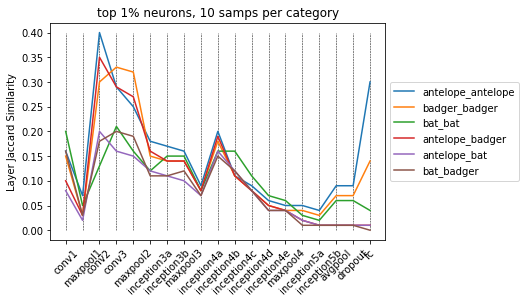

In [ ]:
plt.plot(layers, antelope_antelope_scores_plot, 
         label = 'antelope_antelope')
plt.plot(layers, badger_badger_scores_plot, 
         label = 'badger_badger')
plt.plot(layers, bat_bat_scores_plot, 
         label = 'bat_bat')

plt.plot(layers, antelope_badger_scores_plot, 
         label = 'antelope_badger')
plt.plot(layers, antelope_bat_scores_plot, 
         label = 'antelope_bat')
plt.plot(layers, bat_badger_scores_plot, 
         label = 'bat_badger')

plt.vlines(layers, 0, [0.4]*len(layers), linestyle="dashed", linewidth= 0.5)

ax = plt.gca()
ax.tick_params(axis='x', labelrotation = 45)
plt.title('top 1% neurons, 10 samps per category')
plt.ylabel('Layer Jaccard Similarity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Overall, it's very hard to tell the difference using this method. It's not until Inception5a do we see differences in the plot; before that, the between-categories sometimes score higher on similarity than within-categories.

The within-categories are blue, yellow, and green. At inception 4e, bat-bat has higher than badger-badger


---

Now try 20 samples